# ALY 6110 - FINAL PROJECT - SPOTIFY CHARTS ANALYSIS

# Name of students
1. Trieu Vo
2. Dongkai Yu
3. Jack Brown
4. Chuanzhang Tian
5. Lei Fang

# Problem Understanding

The music industry is growing faster than ever. Each year, new platforms and mediums skyrocket to stand out, make a name for themselves, and reshape the way audiences connect with artists. At the same time, new technologies put creative tools in the hands of people who were previously unable to access them. Obviously, this industry is growing rapidly and becoming more competitive. Companies are having to differentiate themselves by providing unique, artist-focused content or developing different pricing models. Spotify, founded in 2006, has become the most popular streaming platform worldwide. We will use the data set from this platform to analyze song trends of singers. From there, it is possible to suggest solutions to improve the popularity of singers, which in turn will help them be more competitive and successful in the music industry.

# Data Understanding

We use the dataset 'Spotify Charts' from Kaggle, with a file size of 3.48 GB.

It has 26,173,514 observations and 9 columns, including title, rank, date, artist, url, region, chart, trend, and stream. This dataset contains the top 200 streamed tracks on Spotify every day from Jan 1 2017 to Dec 31 2021, collected by using Spotify API. The data is refreshed daily. The original chart is shown in this link: https://spotifycharts.com/regional

There are 9 columns in this dataset and their description are as follows.

title: title of the song

rank: rank from 1 - 200 (1 is the most streamed track that day)

date: date of data

artist: artist name

url: url of the song

region: countries around the world

chart: top200 or viral50

trend: the position of that song on the chart compared to yesterday. It has 3 values: MOVE_UP, MOVE_DOWN or SAME_POSITION 

streams: the total number of global streams of that song in one day


# Import libraries

In [1]:
!pip install pyspark

     |████████████████████████████████| 281.4 MB 30 kB/s               
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=3cf8d9b0d8efd00fe019017cde1a4f066364e9ce2eee72519d2c9a38044d1594
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [2]:
import numpy as np
import pandas as pd
from wordcloud import WordCloud

import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
import pyspark.sql.types as t
import pyspark.sql.functions as f

# Import Data

In [3]:
data = pd.read_csv('/kaggle/input/spotify-charts/charts.csv')

Get the shape of data frame:

In [4]:
data.shape

(26173514, 9)

The number of countries:

In [5]:
len(data['region'].unique())

70

# Get the visualization of artist popularity

In [6]:
def visualize_word_counts(counts):
    wc = WordCloud(max_font_size=130, min_font_size=25, colormap='tab20', background_color='white', 
                   prefer_horizontal=.95, width=2100, height=700, random_state=0)
    cloud = wc.generate_from_frequencies(counts)
    plt.figure(figsize=(18,15))
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [7]:
counts = data['artist'].value_counts()

This counts and sorts all observations of songs by artists in 70 countries in Spotify's Top200:

The top 10 most popular artists:

In [8]:
counts.head(10)

Ed Sheeran         387917
Billie Eilish      251825
Post Malone        211272
Bad Bunny          203403
Ariana Grande      189914
Dua Lipa           187085
Drake              177380
Imagine Dragons    157900
XXXTENTACION       155458
BTS                154338
Name: artist, dtype: int64

The top 10 least popular artists:

In [9]:
counts.tail(10)

Tymek, Kizo, Szpaku, Michał Graczyk, 2K                                    1
Aspova, Motive                                                             1
Creditcard Reasons                                                         1
Lips, Rose McIver                                                          1
Aspova, Ceg                                                                1
Ezhel, Patron, Anıl Piyancı, Sansar Salvo, Allame, Pit10, Beta, Kamufle    1
Lips, George Mason, Rose McIver, Kimbra                                    1
Joakim Kleven, KOH                                                         1
Lazyloxy, Maiyarap, OG-ANIC, UrboyTJ                                       1
Luna 99                                                                    1
Name: artist, dtype: int64

In [10]:
counts.loc['Aspova',]

953

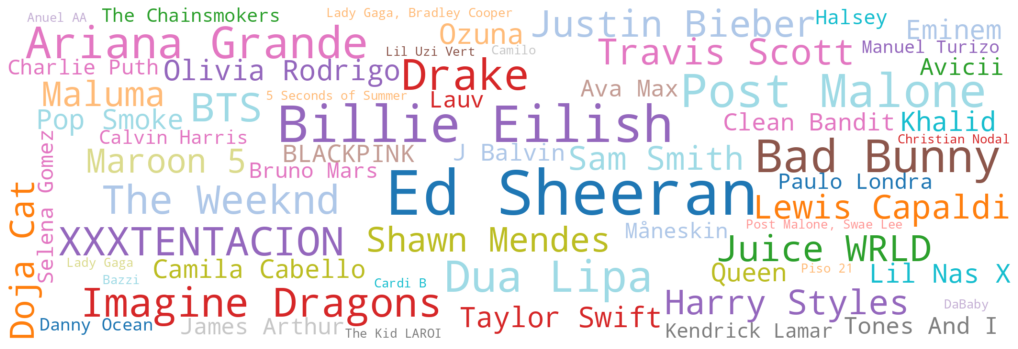

In [11]:
visualize_word_counts(counts)

We are going to compare the trend of songs between the most popular singer Ed Sheeran and the least popular singer Aspova to see the difference. From there we will try to suggest ways to improve their popularity.

# Streams by region
Which region's Top200 list is streamed the most? The result will be somewhat related to the region's population.

In [12]:
# compute total streams by region
streams = data.groupby('region')['streams'].sum().reset_index()

# compute percent stream
streams['percent_streams'] = streams['streams']/streams['streams'].sum()

# rename regions with very little streams (< .01 %) as 'Other'
streams['region'] = streams.apply(lambda x: x['region'] if x['percent_streams'] >= .01 else 'Other', axis=1)

# we need another groupby because there are multiple regions with name 'Other'
streams = streams.groupby('region')['percent_streams'].sum().reset_index().round(3).sort_values(by='percent_streams')

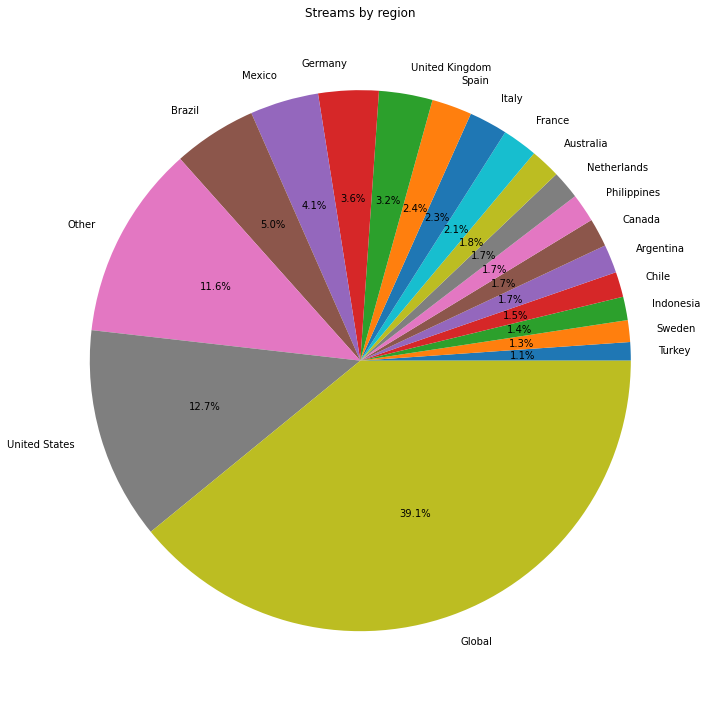

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.pie(x=streams['percent_streams'], labels=streams['region'], autopct='%.1f%%')
ax.set_title('Streams by region')
plt.tight_layout()

Now we try to use Spark and SQL to explore the trends in the dataset:

A SparkSession can be used create:
* DataFrame
* Register DataFrame as tables
* Execute SQL over tables
* Cache tables
* Read parquet files

To create a SparkSession, use the following builder pattern:

In [14]:
spark = (SparkSession.builder.config("spark.driver.memory","4g").config("spark.driver.maxResultSize", "4g").getOrCreate())

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/17 14:48:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Now, we need to import our data again. We are specifying the desire to use dataset csv format.
* “header”: true if the first row in the dataset are column names.
* “inferSchema” instructs Spark to attempt to infer the schema of the CSV

In [15]:
# import dataframe by spark
df = spark.read.csv(path='../input/spotify-charts/charts.csv', inferSchema=True, header=True)

We cannot perform our analysis with all the datatype string. Thus here we parse the datatypes using the format below.

Datatypes supported by Spark: https://spark.apache.org/docs/3.0.0-preview2/sql-ref-datatypes.html

We convert 'rank', 'date' and 'streams' in the original dataset to data types in Spark.

In [16]:
# setting the schema

df = df.withColumn("rank", f.col("rank").cast(t.IntegerType())).withColumn("date", f.col("date").cast(t.DateType())).withColumn("streams", f.col("streams").cast(t.IntegerType()))

Take a look at the DataFrame:

In [17]:
df

DataFrame[title: string, rank: int, date: date, artist: string, url: string, region: string, chart: string, trend: string, streams: int]

To perform analysis, we will be using spark sql library. For that, we create a temp table.

The reason to use the registerTempTable( tableName ) method for a DataFrame, is so that in addition to being able to use the Spark-provided methods of a DataFrame.

Using this, we can also issue SQL queries via the sqlContext. sql( sqlQuery ) method, that use that DataFrame as an SQL table.

In [18]:
# Register a temp table
df.registerTempTable("charts")

/opt/conda/lib/python3.7/site-packages/pyspark/sql/dataframe.py:140: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  FutureWarning


# Get the range of timeline of the data

In [19]:
spark.sql('''
SELECT MIN(date) begin, MAX(date) end 
FROM charts 
WHERE chart = 'top200';
''').toPandas()

,begin,end
0,2017-01-01,2021-12-31


# View the head of the chart

In [20]:
spark.sql('''
SELECT * 
FROM charts 
WHERE chart = 'top200' 
LIMIT 10;
''').toPandas()

,title,rank,date,artist,url,region,chart,trend,streams
0,Chantaje (feat. Maluma),1,2017-01-01,Shakira,https://open.spotify.com/track/6mICuAdrwEjh6Y6...,Argentina,top200,SAME_POSITION,253019
1,Vente Pa' Ca (feat. Maluma),2,2017-01-01,Ricky Martin,https://open.spotify.com/track/7DM4BPaS7uofFul...,Argentina,top200,MOVE_UP,223988
2,Reggaetón Lento (Bailemos),3,2017-01-01,CNCO,https://open.spotify.com/track/3AEZUABDXNtecAO...,Argentina,top200,MOVE_DOWN,210943
3,Safari,4,2017-01-01,"J Balvin, Pharrell Williams, BIA, Sky",https://open.spotify.com/track/6rQSrBHf7HlZjtc...,Argentina,top200,SAME_POSITION,173865
4,Shaky Shaky,5,2017-01-01,Daddy Yankee,https://open.spotify.com/track/58IL315gMSTD37D...,Argentina,top200,MOVE_UP,153956
5,Traicionera,6,2017-01-01,Sebastian Yatra,https://open.spotify.com/track/5J1c3M4EldCfNxX...,Argentina,top200,MOVE_DOWN,151140
6,Cuando Se Pone a Bailar,7,2017-01-01,Rombai,https://open.spotify.com/track/1MpKZi1zTXpERKw...,Argentina,top200,MOVE_DOWN,148369
7,Otra vez (feat. J Balvin),8,2017-01-01,Zion & Lennox,https://open.spotify.com/track/3QwBODjSEzelZyV...,Argentina,top200,MOVE_DOWN,143004
8,La Bicicleta,9,2017-01-01,"Carlos Vives, Shakira",https://open.spotify.com/track/0sXvAOmXgjR2QUq...,Argentina,top200,MOVE_UP,126389
9,Dile Que Tu Me Quieres,10,2017-01-01,Ozuna,https://open.spotify.com/track/20ZAJdsKB5IGbGj...,Argentina,top200,MOVE_DOWN,112012


# Get the total number of observations by all the singers in TOP 200 chart

In [21]:
spark.sql('''
SELECT COUNT(*) NoOfObservationsTop200
FROM charts 
WHERE chart = 'top200';
''').toPandas().head(10)

,NoOfObservationsTop200
0,20318183


=> Over 20 million observations in Top 200 over 4 years (1/1/2017 - 12/31/2021)

# Get the total number of songs by Ed Sheeran & Aspova appeared in Top 200

## Ed Sheeran

In [22]:
spark.sql('''
SELECT COUNT(DISTINCT title) NoOfSongs 
FROM charts 
WHERE artist LIKE '%Ed Sheeran%' AND chart = 'top200';
''').toPandas().head(10)

,NoOfSongs
0,121


## Aspova

In [23]:
spark.sql('''
SELECT COUNT(DISTINCT title) NoOfSongs 
FROM charts 
WHERE artist LIKE '%Aspova%' AND chart = 'top200';
''').toPandas().head(10)

,NoOfSongs
0,23


=> Ed Sheeran's songs appear in the Top 200 6 times more than Aspova's songs in the Top 200

# Count the number of times Ed Sheeran & Aspova appeared in the TOP 200 chart

## Ed Sheeran

In [24]:
spark.sql('''
SELECT COUNT(*) NoInTop200 
FROM charts 
WHERE artist LIKE '%Ed Sheeran%' AND chart = 'top200';
''').toPandas().head(10)

,NoInTop200
0,368388


## Aspova

In [25]:
spark.sql('''
SELECT COUNT(*) NoInTop200 
FROM charts 
WHERE artist LIKE '%Aspova%' AND chart = 'top200';
''').toPandas().head(10)

,NoInTop200
0,1344


=> Ed Sheeran appeared in the Top 200 300 times more than Aspova

# Count the number of times Ed Sheeran and Aspova appeared in the Top 200 while collaborating with other singers

## Ed Sheeran

In [26]:
spark.sql('''
SELECT artist, COUNT(artist) count 
FROM charts 
WHERE artist LIKE '%Ed Sheeran%' AND chart = 'top200' 
GROUP BY artist 
ORDER BY count DESC;
''').toPandas().head(10)

,artist,count
0,Ed Sheeran,366026
1,"Taylor Swift, Ed Sheeran, Future",1995
2,"Tori Kelly, Ed Sheeran",176
3,"Ed Sheeran, Elton John",125
4,"Fireboy DML, Ed Sheeran",19
5,"Alonestar, Rick Live, Ed Sheeran",14
6,"The Weeknd, Ed Sheeran",9
7,"Taylor Swift, Ed Sheeran",8
8,"Alonestar, HerbertSkillz, Ed Sheeran",8
9,"Foy Vance, Ed Sheeran",4


## Aspova

In [27]:
spark.sql('''
SELECT artist, COUNT(artist) count 
FROM charts 
WHERE artist LIKE '%Aspova%' AND chart = 'top200' 
GROUP BY artist 
ORDER BY count DESC;
''').toPandas().head(10)

,artist,count
0,Aspova,762
1,"Şanışer, Kamufle, Mert Şenel, Mirac, Aga B, De...",223
2,"Aspova, Şanışer",96
3,"Aspova, Tanerman",67
4,"Aspova, Patron",52
5,"Tuğkan, Aspova",42
6,"Aspova, Şehinşah",35
7,"Şanışer, Fuat, Ados, Hayki, Server Uraz, Beta ...",32
8,"Vio, Aspova",8
9,"Aspova, Motive, Murgs",7


=> Ed Sheeran and Aspova are both more successful solo.

=> Ed Sheeran's songs are 500 times more popular than Aspova's songs.

# Show the top 10 most popular songs of Ed Sheeran and Aspova

## Ed Sheeran

In [28]:
spark.sql('''
SELECT title, SUM(streams) streams 
FROM charts 
WHERE artist LIKE '%Ed Sheeran%' 
AND streams IS NOT NULL 
GROUP BY title 
ORDER BY streams DESC 
LIMIT 10;
''').toPandas().head(10)

,title,streams
0,Shape of You,5245740051
1,Perfect,3038712776
2,I Don't Care (with Justin Bieber),2296138118
3,Beautiful People (feat. Khalid),1612020133
4,Bad Habits,1473943611
5,Photograph,1081454379
6,Castle on the Hill,1021200333
7,Galway Girl,1007337746
8,Thinking out Loud,853200137
9,Happier,782141998


## Aspova

In [29]:
spark.sql('''
SELECT title, SUM(streams) streams 
FROM charts 
WHERE artist LIKE '%Aspova%' 
AND streams IS NOT NULL 
GROUP BY title 
ORDER BY streams DESC 
LIMIT 10;
''').toPandas().head(10)

,title,streams
0,Eskimiş Senelere,37435814
1,Susamam,20156260
2,Suç,3013264
3,Sağanak,2211168
4,Kader,2141421
5,Kanayan Yaralar,2046450
6,Ecel,2013589
7,Nude,1557447
8,TANIMIYORUM,742503
9,Içinde,361846


=> Shape of You of Ed Sheeran has 5 billion streams, while Eskimiş Senelere of Aspova only has 37 million streams

=> The difference between the top song of Ed Sheeran and Aspova is 135 times

# Count the number of times top songs of Ed Sheeran & Aspova has appeared in top 200

## Ed Sheeran

In [30]:
spark.sql('''
SELECT title, COUNT(title) AS count 
FROM charts 
WHERE artist LIKE '%Ed Sheeran%' 
AND chart = 'top200' 
GROUP BY title 
ORDER BY count DESC;
''').toPandas().head(10)

,title,count
0,Shape of You,65262
1,Perfect,52392
2,Photograph,28605
3,I Don't Care (with Justin Bieber),27101
4,Thinking out Loud,26014
5,Beautiful People (feat. Khalid),21799
6,Happier,17056
7,Galway Girl,15614
8,Castle on the Hill,14653
9,Perfect Duet (Ed Sheeran & Beyoncé),11258


## Aspova

In [31]:
spark.sql('''
SELECT title, COUNT(title) AS count
FROM charts 
WHERE artist LIKE '%Aspova%' 
AND chart = 'top200' 
GROUP BY title 
ORDER BY count DESC;
''').toPandas().head(10)

,title,count
0,Eskimiş Senelere,645
1,Susamam,255
2,Suç,96
3,Sağanak,73
4,Nude,67
5,Kanayan Yaralar,52
6,Ecel,42
7,Kader,35
8,TANIMIYORUM,20
9,Dur Dedik,9


=> Shape of You of Ed has appeared in the Top 200 100 times more than Aspova's Eskimiş Senelere

=> It also the number of days Top songs of Ed Sheeran & Aspova were on the Top 200 chart

=> The number of days Top songs of Ed Sheeran has appeared in the Top 200 100 times more than Aspova's Eskimiş Senelere

=> The top songs of Ed Sheeran meet the demands of audience better than that of Aspova => They last longer on the Spotify Top 200

=> Audience prefers pop music of Ed Sheeran rather than rap music of Aspova

# Get the highest ranks the songs of Ed Sheeran and Aspova have attained

# Get the number of times they have been in that position

## Ed Sheeran

In [32]:
spark.sql('''
SELECT title, MIN(rank) rank, COUNT(rank) count 
FROM charts 
WHERE artist LIKE '%Ed Sheeran%'
AND chart = 'top200' 
AND rank <= 10 
GROUP BY title
ORDER BY rank ASC;
''').toPandas().head(20)

,title,rank,count
0,Shape of You,1,11096
1,Castle on the Hill,1,2213
2,Perfect,1,1933
3,Bad Habits,1,4246
4,Beautiful People (feat. Khalid),1,3071
5,I Don't Care (with Justin Bieber),1,3877
6,Galway Girl,1,1287
7,Shivers,1,1866
8,Perfect Duet (Ed Sheeran & Beyoncé),1,610
9,Antisocial (with Travis Scott),2,256


## Aspova

In [33]:
spark.sql('''
SELECT title, MIN(rank) rank, COUNT(rank) count 
FROM charts 
WHERE artist LIKE '%Aspova%' 
AND chart = 'top200' 
AND rank <= 10 
GROUP BY title
ORDER BY rank ASC;
''').toPandas().head(20)

,title,rank,count
0,Susamam,1,44
1,Eskimiş Senelere,10,1


=> Ed Sheeran has 9 songs in rank 1. Aspova only has 1 song in rank 1.

=> Ed Sheeran's Shape of You is the most loved song and also has the highest chart for a long time worldwide. Aspova's Eskimis Senelere is his most popular song, but it only peaked at number 10 on one occasion.

Susamam is a collaboration song of Aspova and it ranks 1 => Collaboration is better for Aspova to be more popular than solo.

=> Shape of You is Ed Sheeran's most successful song. It stayed at #1 for 6 times longer than the second song Castle of the Hill

# Count the number times Ed Sheeran and Aspova have been on the 1st rank

## Ed Sheeran

In [34]:
spark.sql('''
SELECT COUNT(*) NoOfRank1 
FROM charts 
WHERE artist LIKE '%Ed Sheeran%' 
AND chart = 'top200' 
AND rank = 1;
''').toPandas().head(10)

,NoOfRank1
0,4810


## Aspova

In [35]:
spark.sql('''
SELECT COUNT(*) NoOfRank1 
FROM charts 
WHERE artist LIKE '%Aspova%' 
AND chart = 'top200' 
AND rank = 1;
''').toPandas().head(10)

,NoOfRank1
0,14


=> Ed Sheeran has been in rank 1 400 times more than Aspova

# Calculate the highest, lowest and the mean rank of the songs of Ed Sheeran and Aspova

## Ed Sheeran

In [36]:
spark.sql('''
SELECT Title, MIN(rank) Highest, MAX(rank) Lowest, AVG(rank) Avg 
FROM charts 
WHERE artist like '%Ed Sheeran%' 
AND chart='top200' 
GROUP BY title 
ORDER BY Highest;
''').toPandas().head(10)

,Title,Highest,Lowest,Avg
0,Beautiful People (feat. Khalid),1,200,77.225240
1,Galway Girl,1,200,80.686499
2,Shape of You,1,200,80.527842
3,I Don't Care (with Justin Bieber),1,200,77.736910
4,Perfect Duet (Ed Sheeran & Beyoncé),1,200,101.299698
5,Castle on the Hill,1,200,86.030779
6,Perfect,1,200,102.164930
7,Bad Habits,1,200,41.974160
8,Shivers,1,200,41.899490
9,Eraser,2,200,97.767938


## Aspova

In [37]:
spark.sql('''
SELECT Title, MIN(rank) Highest, MAX(rank) Lowest, AVG(rank) Avg 
FROM charts 
WHERE artist like '%Aspova%' 
AND chart='top200' 
GROUP BY title 
ORDER BY Highest;
''').toPandas().head(10)

,Title,Highest,Lowest,Avg
0,Susamam,1,198,91.403922
1,Eskimiş Senelere,10,200,68.116279
2,Kanayan Yaralar,17,198,109.826923
3,Kader,21,192,84.000000
4,Içinde,30,177,94.750000
5,Ecel,31,156,95.714286
6,Suç,43,200,126.385417
7,TANIMIYORUM,51,197,122.500000
8,Nude,72,199,162.313433
9,Sür,73,190,140.000000


=> Ed Sheeran has much more songs in rank 1 than Aspova

=> Most songs of Aspova are around rank 50

# Show the trends of top songs of Ed Sheeran and Aspova over time

## Ed Sheeran

In [38]:
q = spark.sql('''
SELECT title, YEAR(date) year, date, rank, region 
FROM charts 
WHERE title IN ('Shape of You','Castle on the Hill','Perfect') 
AND chart='top200'
ORDER BY rank ASC;''').toPandas()

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Trends in Top 200')

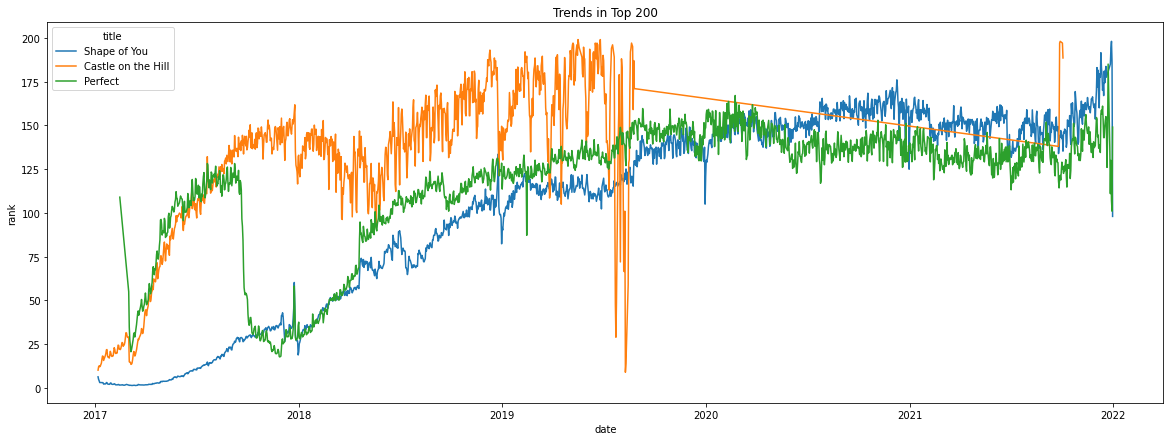

In [39]:
fig, axes = plt.subplots(figsize=(20,7))
sns.lineplot('date', 'rank', data=q, hue='title', ci=None).set_title('Trends in Top 200')

## Aspova

In [40]:
p = spark.sql('''
SELECT title, YEAR(date) year, date, rank, region 
FROM charts 
WHERE title IN ('Eskimiş Senelere','Susamam','Suç') 
AND chart='top200'
ORDER BY rank ASC;''').toPandas()

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Trends in Top 200')

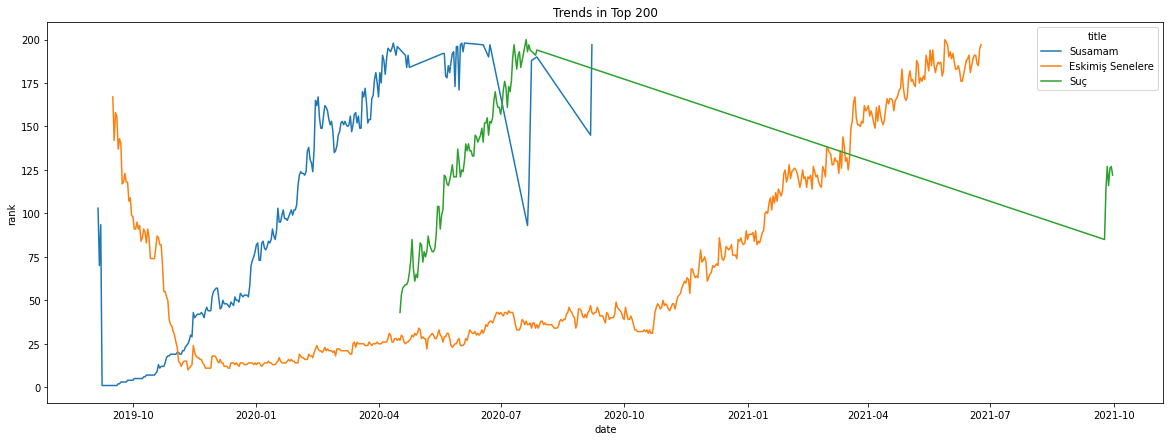

In [41]:
fig, axes = plt.subplots(figsize=(20,7))
sns.lineplot('date', 'rank', data=p, hue='title', ci=None).set_title('Trends in Top 200')

=> Songs of Ed Sheeran began in rank 1 and slowly decreased to rank 200, but still in the Top 200 chart

=> Songs of Aspova began in rank below 100, then quickly increased to rank 1, then slowly decreased to rank 200 and then were out of Top 200 chart

# Recommendation

Ed Sheeran's songs appear in the Top 200 6 times more than Aspova's songs. Ed Sheeran appeared in the Top 200 300 times more than Aspova. Ed Sheeran has been in rank 1 400 times more than Aspova. Ed Sheeran's songs are 500 times more popular than Aspova's songs. The difference between the top song of Ed Sheeran and Aspova is 135 times => Aspova should focus on quality of his songs and marketing more than the number of his songs.

Ed Sheeran has 9 songs in rank 1. Aspova only has 1 song in rank 1. Ed Sheeran's better in solo songs. Aspova's Susamam is a created by Aspova and many artists, and it has rank 1 => Aspova should collaborate with famous artists to make his music product much more popular.

Ed Sheeran has much more songs in rank 1 than Aspova. Most songs of Aspova are around rank 50 => Aspova should focus on the quality of his songs. Also, he should focus on marketing to make his songs popular for a long time, not a short time.

Songs of Ed Sheeran began in rank 1 and slowly decreased to rank 200, but still in the Top 200 chart. Songs of Aspova began in rank under 100, then quickly increased to rank 1, then slowly decreased to rank 200 and then were out of Top 200 chart => Aspova should focus on the long-run marketing to keep his songs on top.

Songs of Ed Sheeran are in English so they keep being popular for a long time all over the world. Songs of Aspova are in Turkish so they were only popular in Turkey for a short of time, then disappeared => Aspova should publish more songs in English, join the global music market.